In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout, Dense, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
maotai = pd.read_csv("./SH600519.csv")
train_set = maotai.iloc[:2426-300,2:3].values
test_set = maotai.iloc[2426-300:, 2:3].values

sc = MinMaxScaler(feature_range=(0,1))
train_set_scale = sc.fit_transform(train_set)
test_set_scale = sc.transform(test_set)

In [12]:
x_train, y_train = [],[]
x_test, y_test = [],[]

In [13]:
for i in range(60,len(train_set_scale)):
    x_train.append(train_set_scale[i-60:i,0])
    y_train.append(train_set_scale[i,0])
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0], 60, 1))

In [14]:
for i in range(60,len(test_set_scale)):
    x_test.append(test_set_scale[i-60:i,0])
    y_test.append(test_set_scale[i,0])
    
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0],60,1))

In [15]:
model = tf.keras.models.Sequential([
    GRU(80, return_sequences=True),
    Dropout(0.2),
    GRU(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
             loss = 'mean_squared_error')

model_save_path = './gru_maotai_checkpoint/gru_maotai.ckpt'
if os.path.exists(model_save_path+'.index'):
    print("------------load model------------")
    model.load_weights(model_save_path)
    
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                monitor='val_loss')
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                   callbacks=[cp_callback])
model.summary()

Epoch 1/50
65/65 [==============================] - 5s 35ms/step - loss: 0.0183 - val_loss: 1.1296e-04
Epoch 2/50
65/65 [==============================] - 2s 30ms/step - loss: 0.0011 - val_loss: 1.0332e-04
Epoch 3/50
65/65 [==============================] - 2s 31ms/step - loss: 0.0011 - val_loss: 1.6073e-04
Epoch 4/50
65/65 [==============================] - 2s 30ms/step - loss: 9.3390e-04 - val_loss: 2.2640e-04
Epoch 5/50
65/65 [==============================] - 2s 30ms/step - loss: 8.3543e-04 - val_loss: 9.6461e-05
Epoch 6/50
65/65 [==============================] - 2s 31ms/step - loss: 7.5997e-04 - val_loss: 1.1001e-04
Epoch 7/50
65/65 [==============================] - 2s 31ms/step - loss: 8.6690e-04 - val_loss: 1.4868e-04
Epoch 8/50
65/65 [==============================] - 2s 31ms/step - loss: 8.0223e-04 - val_loss: 8.4075e-05
Epoch 9/50
65/65 [==============================] - 2s 31ms/step - loss: 6.8040e-04 - val_loss: 9.1634e-05
Epoch 10/50
65/65 [==============================

In [16]:
with open("GRU_maotai_weights.txt",'w') as f:
    for v in model.trainable_variables:
        f.write(str(v.name)+'\n')
        f.write(str(v.shape)+'\n')
        f.write(str(v.numpy())+'\n')



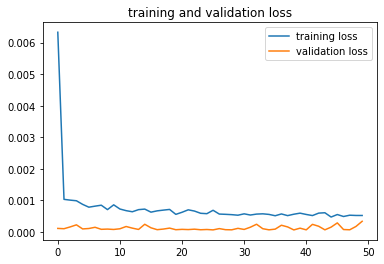

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title("training and validation loss")
plt.legend()
plt.show()

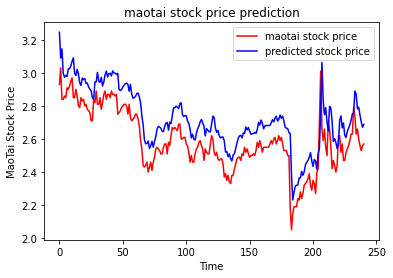

In [20]:
predicted_price = sc.inverse_transform(model.predict(x_test))
real_price = test_set[60:]
plt.plot(real_price, color='red', label='maotai stock price')
plt.plot(predicted_price, color='blue', label='predicted stock price')
plt.title("maotai stock price prediction")
plt.xlabel("Time")
plt.ylabel("MaoTai Stock Price")
plt.legend()
plt.show()

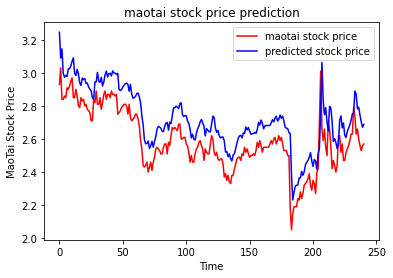

In [21]:
predicted_price = sc.inverse_transform(model.predict(x_test))
real_price = sc.inverse_transform(test_set_scale[60:])
plt.plot(real_price, color='red', label='maotai stock price')
plt.plot(predicted_price, color='blue', label='predicted stock price')
plt.title("maotai stock price prediction")
plt.xlabel("Time")
plt.ylabel("MaoTai Stock Price")
plt.legend()
plt.show()

In [23]:
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_price, real_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_price, real_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_price, real_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)


均方误差: 0.022246
均方根误差: 0.149150
平均绝对误差: 0.138568
